In [1]:
# Setup & Imports
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# Extract Data (Update path to where you uploaded data.zip)
zip_path = '/content/drive/MyDrive/project/data.zip'
extract_path = '/content/project_data'

if not os.path.exists(extract_path):
    print("Extracting data...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
      print("Extraction complete.")

DATA_DIR = os.path.join(extract_path, 'data')
IMAGE_DIR = os.path.join(DATA_DIR, 'images')
TRAIN_CSV = os.path.join(DATA_DIR, 'processed_train.csv')
TEST_CSV = os.path.join(DATA_DIR, 'processed_test.csv')

df_full = pd.read_csv(TRAIN_CSV)
df_submission = pd.read_csv(TEST_CSV)

print(f"Training Samples: {len(df_full)}")
print(f"Submission Samples: {len(df_submission)}")

Mounted at /content/drive
Extracting data...
Extraction complete.
Training Samples: 16110
Submission Samples: 5404


Training Tabular Model...
----- Baseline (Tabular Only) Results -----
RMSE (log): 0.1715
R²: 0.8926


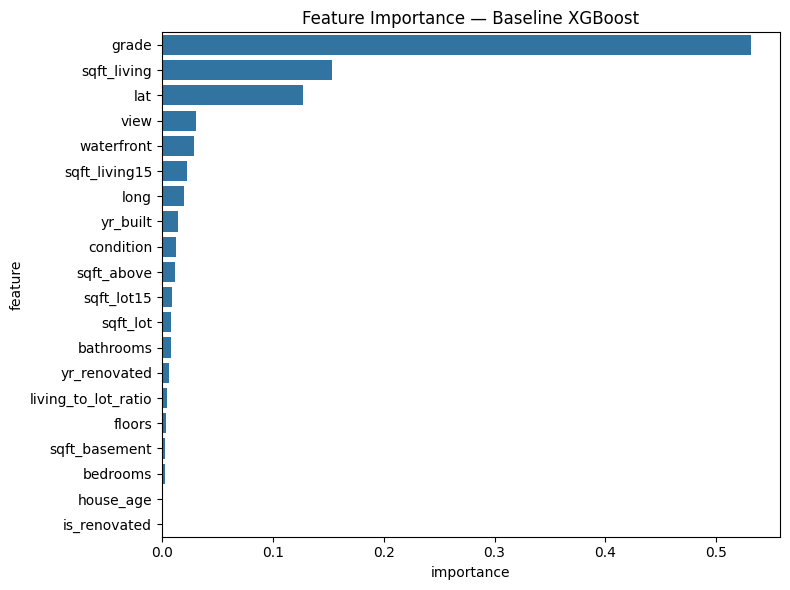

In [2]:
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

tabular_features = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
    'waterfront','view','condition','grade',
    'sqft_above','sqft_basement',
    'yr_built','yr_renovated',
    'lat','long',
    'sqft_living15','sqft_lot15','house_age','is_renovated','living_to_lot_ratio'
]

X = df_full[tabular_features]
y = np.log1p(df_full["price"]) # Log transform price

# Split
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

print("Training Tabular Model...")
model_tab = XGBRegressor(
    n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1
)

model_tab.fit(X_tr, y_tr)

val_preds = model_tab.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2   = r2_score(y_val, val_preds)

print("----- Baseline (Tabular Only) Results -----")
print(f"RMSE (log): {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Feature Importance Plot
importance_df = pd.DataFrame({
    "feature": tabular_features,
    "importance": model_tab.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x="importance", y="feature")
plt.title("Feature Importance — Baseline XGBoost")
plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing on: {device}")

ImageFile.LOAD_TRUNCATED_IMAGES = True

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class PropertyImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform_pipeline):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform_pipeline
        self.id_list = dataframe['id'].tolist()

    def __len__(self):
        return len(self.id_list)

    def __getitem__(self, idx):
        current_id = self.id_list[idx]
        file_name = f"{current_id}.jpg"
        file_path = os.path.join(self.root_dir, file_name)

        try:
            img = Image.open(file_path).convert("RGB")
            img_tensor = self.transform(img)
        except (OSError, FileNotFoundError):
            img_tensor = torch.zeros((3, 224, 224))

        return img_tensor, current_id

train_dataset = PropertyImageDataset(df_full, IMAGE_DIR, img_transforms)
test_dataset  = PropertyImageDataset(df_submission, IMAGE_DIR, img_transforms)

train_gen = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)
test_gen  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load Model (ResNet18)
print("Initializing Feature Extractor (ResNet18)...")
feature_extractor = models.resnet18(pretrained=True)
feature_extractor.fc = nn.Identity()

for p in feature_extractor.parameters():
    p.requires_grad = False

feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

def get_image_features(model, loader, dataset_name="Data"):
    output_dict = {}
    print(f"Extracting features for {dataset_name}...")

    with torch.no_grad():
        for inputs, identifiers in tqdm(loader):
            inputs = inputs.to(device)
            features = model(inputs).cpu().numpy()
            for i, uid in enumerate(identifiers):
                clean_id = int(uid.item()) if isinstance(uid, torch.Tensor) else int(uid)
                output_dict[clean_id] = features[i]

    return output_dict

train_feats_dict = get_image_features(feature_extractor, train_gen, "Training Set")
test_feats_dict  = get_image_features(feature_extractor, test_gen, "Submission Set")

def create_embedding_df(data_dict):
    df = pd.DataFrame.from_dict(data_dict, orient="index")
    df.index.name = "id"
    df.reset_index(inplace=True)
    df.columns = ["id"] + [f"img_{i}" for i in range(512)]
    return df

print("Formatting DataFrames...")
df_emb_train = create_embedding_df(train_feats_dict)
df_emb_test = create_embedding_df(test_feats_dict)

df_full["id"] = df_full["id"].astype(int)
df_submission["id"] = df_submission["id"].astype(int)
df_emb_train["id"] = df_emb_train["id"].astype(int)
df_emb_test["id"] = df_emb_test["id"].astype(int)

df_train_combined = df_full.merge(df_emb_train, on="id", how="inner")
df_test_combined = df_submission.merge(df_emb_test, on="id", how="inner")

HYBRID_DATA_PATH = '/content/drive/MyDrive/project/hybrid_inputs'
if not os.path.exists(HYBRID_DATA_PATH):
    os.makedirs(HYBRID_DATA_PATH)

train_save_path = os.path.join(HYBRID_DATA_PATH, "train_final.csv")
test_save_path = os.path.join(HYBRID_DATA_PATH, "test_final.csv")

df_train_combined.to_csv(train_save_path, index=False)
df_test_combined.to_csv(test_save_path, index=False)

print("\nPROCESS COMPLETE")
print(f"Train Data Shape: {df_train_combined.shape}")
print(f"Test Data Shape:  {df_test_combined.shape}")
print(f"Saved to: {HYBRID_DATA_PATH}")

Processing on: cuda
Initializing Feature Extractor (ResNet18)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features for Training Set...


  0%|          | 0/504 [00:00<?, ?it/s]

Extracting features for Submission Set...


  0%|          | 0/169 [00:00<?, ?it/s]

Formatting DataFrames...

PROCESS COMPLETE
Train Data Shape: (16110, 536)
Test Data Shape:  (5404, 535)
Saved to: /content/drive/MyDrive/project/hybrid_inputs


In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

print("Loading data for Image-Only model...")
train_df = pd.read_csv('/content/drive/MyDrive/project/hybrid_inputs/train_final.csv')

img_cols = [f"img_{i}" for i in range(512)]

X_img = train_df[img_cols].values
y = np.log1p(train_df["price"].values)

# PCA (Dimensionality Reduction)
print("Running PCA (reducing 512 features to 50)...")
pca = PCA(n_components=50, random_state=42)
X_img_pca = pca.fit_transform(X_img)

# Split Data
X_tr, X_val, y_tr, y_val = train_test_split(
    X_img_pca, y, test_size=0.2, random_state=42
)
# Scale Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

# Train XGBoost
print("Training Image-Only XGBoost...")
model_img = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.1,
    reg_lambda=1.5,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_img.fit(X_tr, y_tr)

# Evaluate
val_preds = model_img.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2   = r2_score(y_val, val_preds)

print("\n----- Image-Only Results -----")
print(f"Image-Only RMSE (log): {rmse:.4f}")
print(f"Image-Only R²: {r2:.4f}")

Loading data for Image-Only model...
Running PCA (reducing 512 features to 50)...
Training Image-Only XGBoost...

----- Image-Only Results -----
Image-Only RMSE (log): 0.4303
Image-Only R²: 0.3241


In [6]:
print("Loading data...")
train_df = pd.read_csv('/content/drive/MyDrive/project/hybrid_inputs/train_final.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/project/hybrid_inputs/test_final.csv')

tabular_features = [
    'bedrooms','bathrooms','sqft_living','sqft_lot','floors',
    'waterfront','view','condition','grade',
    'sqft_above','sqft_basement',
    'yr_built','yr_renovated',
    'lat','long',
    'sqft_living15','sqft_lot15','house_age','is_renovated','living_to_lot_ratio'
]

img_cols = [f"img_{i}" for i in range(512)]

# Extract Arrays
print("Preparing arrays...")
X_tab_raw = train_df[tabular_features].values
X_img_raw = train_df[img_cols].values
y = np.log1p(train_df["price"].values)

# Extract for submission later
X_tab_test_raw = test_df[tabular_features].values
X_img_test_raw = test_df[img_cols].values

# Dimensionality Reduction (PCA)
print("Running PCA on image features...")
pca = PCA(n_components=20, random_state=42)
X_img_pca = pca.fit_transform(X_img_raw)
X_img_test_pca = pca.transform(X_img_test_raw)

# Split Data (Train/Validation)
X_tab_tr, X_tab_val, X_img_tr, X_img_val, y_tr, y_val = train_test_split(
    X_tab_raw, X_img_pca, y, test_size=0.2, random_state=42
)

# Scaling (Scale Tabular and Image features separately)
sc_tab = StandardScaler()
sc_img = StandardScaler()

# Fit on training portion only
X_tab_tr = sc_tab.fit_transform(X_tab_tr)
X_img_tr = sc_img.fit_transform(X_img_tr)

# Transform validation portion
X_tab_val = sc_tab.transform(X_tab_val)
X_img_val = sc_img.transform(X_img_val)

# Fuse Features (Concatenate)
X_tr_fused = np.hstack([X_tab_tr, X_img_tr])
X_val_fused = np.hstack([X_tab_val, X_img_val])

# Train XGBoost Model
print("Training Hybrid XGBoost Model...")
model_hybrid = XGBRegressor(
    n_estimators=900,
    learning_rate=0.03,
    max_depth=7,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.75,
    colsample_bytree=0.75,
    reg_alpha=0.1,
    reg_lambda=1.5,
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

model_hybrid.fit(X_tr_fused, y_tr)

# Evaluate
val_preds = model_hybrid.predict(X_val_fused)
rmse = np.sqrt(mean_squared_error(y_val, val_preds))
r2   = r2_score(y_val, val_preds)

print("\n----- Hybrid Results -----")
print(f"Hybrid RMSE (log): {rmse:.4f}")
print(f"Hybrid R²: {r2:.4f}")

# Generate Submission File
print("\nGenerating submission...")

# Prepare test set
X_tab_test_scaled = sc_tab.transform(X_tab_test_raw)
X_img_test_scaled = sc_img.transform(X_img_test_pca)
X_test_fused = np.hstack([X_tab_test_scaled, X_img_test_scaled])

# Predict
test_log_preds = model_hybrid.predict(X_test_fused)
test_price_preds = np.expm1(test_log_preds)

submission = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_price_preds
})

submission.to_csv("submission.csv", index=False)
print("Submission saved as 'submission.csv'")
submission.head()

Loading data...
Preparing arrays...
Running PCA on image features...
Training Hybrid XGBoost Model...

----- Hybrid Results -----
Hybrid RMSE (log): 0.1671
Hybrid R²: 0.8980

Generating submission...
Submission saved as 'submission.csv'


,id,predicted_price
0,2591820310,3.845178e+05
1,7974200820,8.385311e+05
2,7701450110,1.147675e+06
3,9522300010,1.537528e+06
4,9510861140,7.164856e+05


[INFO] Generating EDA Visualizations...


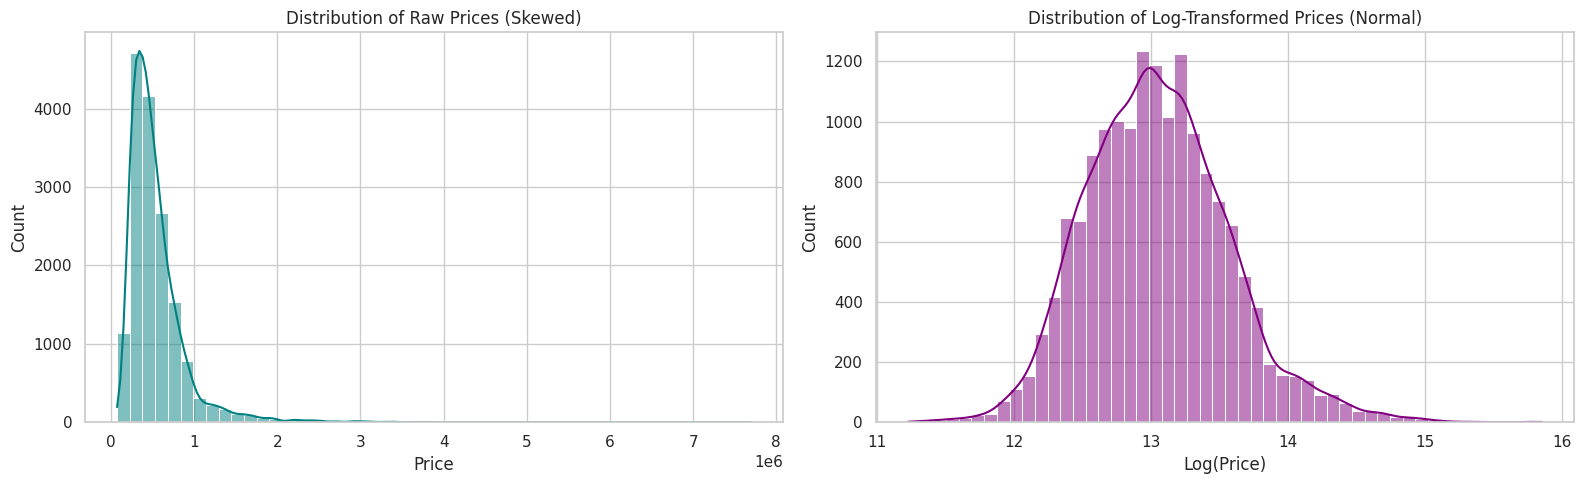

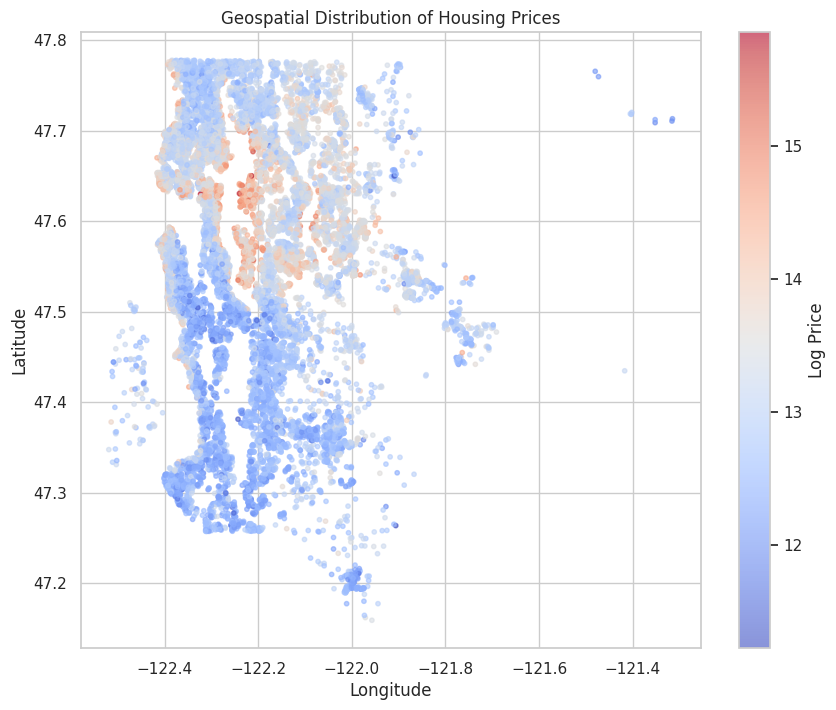

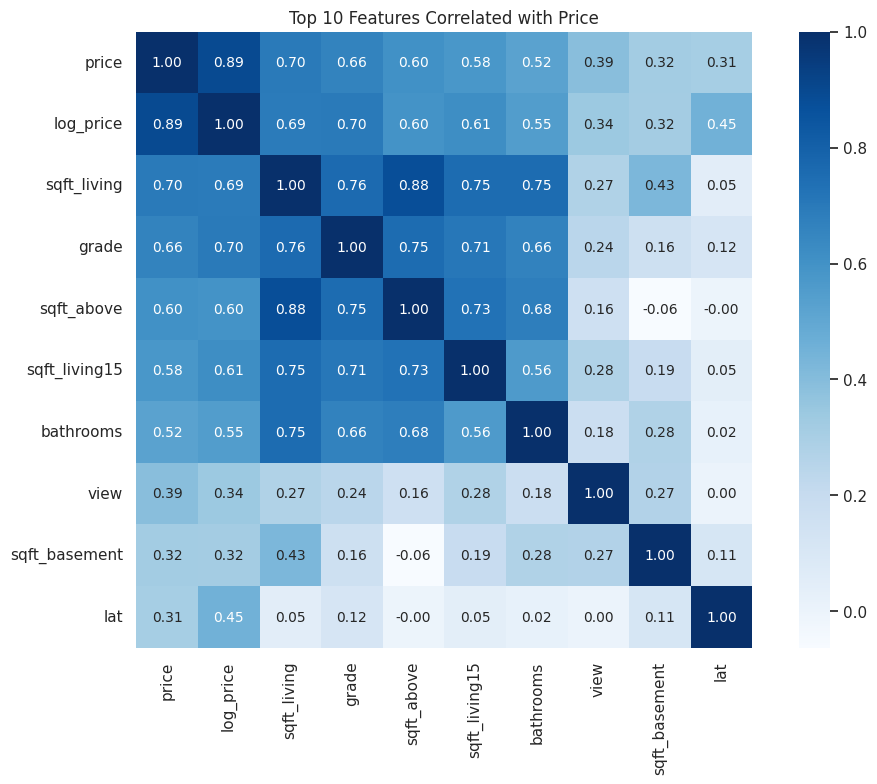

In [9]:
def perform_eda(df):
    print("[INFO] Generating EDA Visualizations...")
    sns.set(style="whitegrid")

    # Target Distribution (Price vs Log Price)
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    # Raw Price
    sns.histplot(df['price'], bins=50, kde=True, ax=ax[0], color='teal')
    ax[0].set_title('Distribution of Raw Prices (Skewed)')
    ax[0].set_xlabel('Price')

    # Log Price
    if 'log_price' not in df.columns:
        df['log_price'] = np.log1p(df['price'])

    sns.histplot(df['log_price'], bins=50, kde=True, ax=ax[1], color='purple')
    ax[1].set_title('Distribution of Log-Transformed Prices (Normal)')
    ax[1].set_xlabel('Log(Price)')

    plt.tight_layout()
    plt.show()

    # Geospatial Analysis (Price Map)
    plt.figure(figsize=(10, 8))
    points = plt.scatter(df['long'], df['lat'],
                         c=df['log_price'],
                         cmap='coolwarm',
                         alpha=0.6,
                         s=10)
    plt.colorbar(points, label='Log Price')
    plt.title('Geospatial Distribution of Housing Prices')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

    plt.figure(figsize=(12, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()

    # Filter for top correlations with price
    cols = corr.nlargest(10, 'price')['price'].index
    cm = np.corrcoef(df[cols].values.T)

    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='Blues')
    plt.title('Top 10 Features Correlated with Price')
    plt.show()

# Execute EDA on the Training Data
perform_eda(train_df)

# GRAD-CAM

In [13]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2

# Device Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class SaliencyGenerator:
    def __init__(self):
        print("Initializing Saliency Generator (ResNet18)...")
        self.model = models.resnet18(pretrained=True).to(DEVICE)
        self.model.eval()
        self.gradients = None
        self.activations = None

        self.target_layer = self.model.layer4[-1].conv2
        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_full_backward_hook(self._backward_hook)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, img_path):
        try:
            raw_img = Image.open(img_path).convert("RGB")
            img_tensor = self.transform(raw_img).unsqueeze(0).to(DEVICE)
        except Exception as e:
            print(f"[WARN] Could not load {img_path}: {e}")
            return None, None

        features = self.model(img_tensor)

        self.model.zero_grad()
        loss = features.mean()
        loss.backward()

        grads = self.gradients[0]            # [512, 7, 7]
        acts = self.activations[0]           # [512, 7, 7]

        weights = grads.mean(dim=(1, 2))

        cam = torch.sum(weights[:, None, None] * acts, dim=0)

        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()

        return cam.detach().cpu().numpy(), raw_img

    @staticmethod
    def overlay_heatmap(raw_img, cam_mask):
        img_np = np.array(raw_img.resize((224, 224)))
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        cam_resized = cv2.resize(cam_mask, (224, 224))

        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)
        return overlay
explainer = SaliencyGenerator()

Initializing Saliency Generator (ResNet18)...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
import os
import shutil

INPUT_DIR = '/content/project_data/data/images'
OUTPUT_DIR = "/content/gradcam_outputs"

if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

def run_batch_explanation(n_samples=25):
    print(f"Generating Grad-CAM for {n_samples} random properties...")

    all_files = [f for f in os.listdir(INPUT_DIR) if f.endswith('.jpg')]
    if len(all_files) == 0:
        print("[ERROR] No images found. Check INPUT_DIR.")
        return []

    selected_files = np.random.choice(all_files, size=n_samples, replace=False)

    saved_paths = []

    for fname in selected_files:
        full_path = os.path.join(INPUT_DIR, fname)
        heatmap, raw_img = explainer.generate_heatmap(full_path)

        if heatmap is not None:
            final_img = explainer.overlay_heatmap(raw_img, heatmap)

            save_name = fname.replace(".jpg", "_gradcam.png")
            save_path = os.path.join(OUTPUT_DIR, save_name)
            cv2.imwrite(save_path, final_img)
            saved_paths.append(save_path)

    print(f"Generated {len(saved_paths)} explanation images.")
    return saved_paths

# Execute
generated_files = run_batch_explanation(n_samples=20)

Generating Grad-CAM for 20 random properties...
Generated 20 explanation images.


[INFO] Zipping files to /content/drive/MyDrive/project/gradcam_visuals.zip...

>>> VISUAL EXPLAINABILITY SAMPLES <<<
(Red areas indicate high importance to the model)


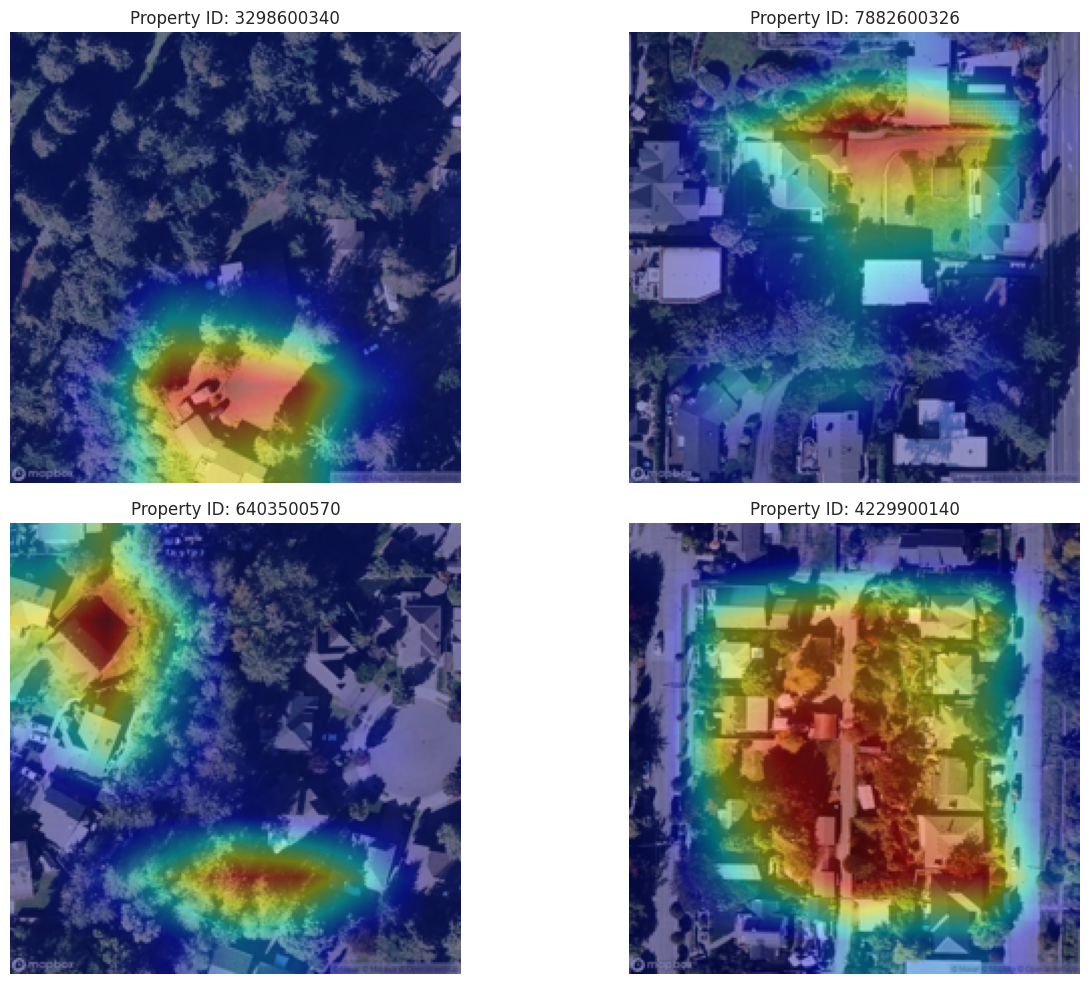

In [15]:
import matplotlib.pyplot as plt

ZIP_PATH = "/content/drive/MyDrive/project/gradcam_visuals.zip"
print(f"[INFO] Zipping files to {ZIP_PATH}...")
shutil.make_archive(ZIP_PATH.replace('.zip', ''), 'zip', OUTPUT_DIR)

print("\n>>> VISUAL EXPLAINABILITY SAMPLES <<<")
print("(Red areas indicate high importance to the model)")

if len(generated_files) >= 4:
    plt.figure(figsize=(14, 10))

    for i in range(4):
        img_path = generated_files[i]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(2, 2, i + 1)
        plt.imshow(img)
        plt.title(f"Property ID: {os.path.basename(img_path).split('_')[0]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("[WARN] Not enough images generated to create a grid plot.")